In [18]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from proj1_helpers import *
from data_cleaning import *
import implementations as imp
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data

In [2]:
y_train, x_train, ids_train = load_csv_data("../data/train.csv")
y_test, x_test, ids_test = load_csv_data("../data/test.csv")

In [3]:
y_test

array([1., 1., 1., ..., 1., 1., 1.])

# Clean test data and add features

In [4]:
NUM_JETS = 4

PRI_jet_num_train = np.array([x_train[:, COLUMN_TO_DROP]]).astype(int)
print(PRI_jet_num_train)
del_x_train = np.delete(x_train, COLUMN_TO_DROP, axis=1)
print(del_x_train.shape)

replaced_x_train = replace_undefined_with_mean(del_x_train, UNDEFINED_VALUE)

norm_x_train, train_data_mean, train_data_std = mean_std_normalization(replaced_x_train)

print(norm_x_train[0][0])
print(norm_x_train.shape)

[[2 1 1 ... 1 0 0]]
(250000, 29)
0.4567790596384003
(250000, 29)


# Do the same for the test data

In [5]:
PRI_jet_num_test = np.array([x_test[:, COLUMN_TO_DROP]]).astype(int)
print(PRI_jet_num_test)
print(PRI_jet_num_test.shape)
del_x_test = np.delete(x_test, COLUMN_TO_DROP, axis=1)
print(del_x_test.shape)

replaced_x_test = replace_undefined_with_mean(del_x_test, UNDEFINED_VALUE)

norm_x_test, test_data_mean, test_data_std = mean_std_normalization(replaced_x_test, train_data_mean, train_data_std)
print(norm_x_test[0][0])
print(norm_x_test.shape)



[[0 1 0 ... 0 1 0]]
(1, 568238)
(568238, 29)
-1.0911994002397385
(568238, 29)


# Train model

In [38]:
#hyperparameters
init_w = np.ones(30)
max_iters = 100
gamma_list = np.logspace(-9,-1,20)
degree_list = range(8,15)
lambda_list = np.linspace(0.05,1)
b_size = 1
ratio = 0.5
seed = 2

best_gamma = np.zeros(4)
best_degree = np.zeros(4,int)
best_score = np.zeros(4)
all_scores = np.zeros([len(gamma_list), len(degree_list)])
d = 0
g = 0
for degree in degree_list:
    print("running with degree = {}".format(degree))
    for i in range(NUM_JETS):
        curr_x = norm_x_train[PRI_jet_num_train[0,:]==i]
        curr_y = y_train[PRI_jet_num_train[0,:]==i]


        (tr_x, tr_y, te_x,te_y) = split_data(curr_x, curr_y, ratio, seed)
        
        px_tr = build_poly(tr_x,degree)
        px_te = build_poly(te_x,degree)
        g = 0
        for gamma in gamma_list:

            _, w = imp.ridge_regression(tr_y,px_tr, gamma)
            y_validation = predict_labels(w, px_te)
            score = sum(y_validation == te_y)/len(te_y)
            
            if score > best_score[i]:
                best_gamma[i] = gamma
                best_degree[i] = degree
                best_score[i] = score
            all_scores[g,d] = all_scores[g,d] + score*sum(PRI_jet_num_train[0,:]==i)/len(norm_x_train)
            g = g+1
    d = d+1

running with degree = 8
running with degree = 9
running with degree = 10
running with degree = 11
running with degree = 12
running with degree = 13
running with degree = 14


# Test accuracy

In [7]:
#calc actual score
actual_score = 0
for i in range(NUM_JETS):
    actual_score = actual_score + best_score[i]*sum(PRI_jet_num_train[0,:]==i)/len(norm_x_train)

print(actual_score)

0.8294332883739738


# Create submission

In [8]:
for i in range(NUM_JETS):
    curr_x = norm_x_train[PRI_jet_num_train[0,:]==i]
    curr_y = y_train[PRI_jet_num_train[0,:]==i]
    
    px_tr = build_poly(curr_x,best_degree[i])
    #(tr_x, tr_y, te_x,te_y) = split_data(curr_x, curr_y, 0.8, 8)
        
    #px_tr = build_poly(tr_x,best_degree[i])
    #px_te = build_poly(te_x,best_degree[i])
    _, w = imp.ridge_regression(curr_y, px_tr, best_gamma[i])
    
    curr_x_test = norm_x_test[PRI_jet_num_test[0,:]==i]
    px_test = build_poly(curr_x_test,best_degree[i])

    y_test[PRI_jet_num_test[0,:]==i] = predict_labels(w, px_test)
    #y_validation = predict_labels(w, px_te)
    #score = sum(y_validation == te_y)/len(te_y)
    #print(score)

In [9]:
create_csv_submission(ids_test, y_test, "y_pred.csv")

# Visualize data

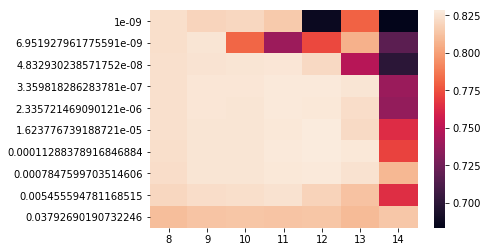

In [43]:
heatmap_fig = sns.heatmap(all_scores[::2,:], xticklabels=degree_list, yticklabels=gamma_list[::2])
heatmap_fig.get_figure().savefig('ridge_regression.png', bbox_inches='tight')


In [37]:
print(best_gamma)
print(best_degree)
print(best_score)

[1.62377674e-06 7.84759970e-05 4.28133240e-06 3.79269019e-03]
[11 12 13 12]
[0.8434854  0.80674198 0.83398174 0.8332431 ]
